In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm import tqdm
import zipfile, shutil
import cv2,h5py
import os, sys, glob
import itertools
import random

%matplotlib inline

/home/fountainhead_gq/anaconda3/envs/tensorflow_p35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train = pd.read_csv('labels.csv')
print(train.shape)

(10222, 2)


In [3]:
train.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
train_id = train.drop('breed', axis=1)
train_breed = train['breed']

breed_class = len(set(train_breed))
breed = set(train_breed)
class_to_num = dict(zip(breed, range(breed_class)))

In [5]:
img_width = 299
X = np.zeros((len(train), img_width, img_width, 3), dtype=np.uint8)
y = np.zeros((len(train), breed_class), dtype=np.uint8)

for i in tqdm(range(len(train))):
    X[i] = cv2.resize(cv2.imread('train/%s.jpg' % train['id'][i]), (img_width, img_width))
    y[i][class_to_num[train['breed'][i]]] = 1

100%|██████████| 10222/10222 [00:41<00:00, 247.32it/s]


In [6]:
X.shape

(10222, 299, 299, 3)

In [7]:
def visual_image(X, y, img_num, dog_breed):
    plt.figure(figsize=(15, 7))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        rand = random.randint(0, img_num-1)
        img = X[rand][:,:,::-1]
        plt.title(y[rand])
        plt.imshow(img)
        plt.title(dog_breed[y[rand].argmax()])

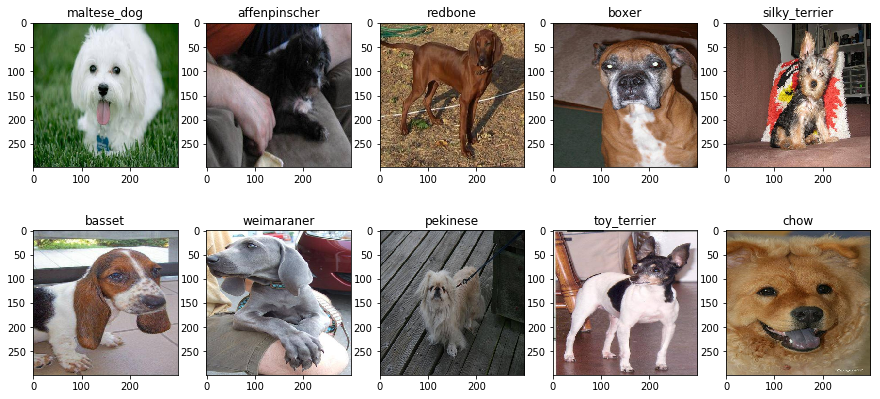

In [8]:
dog_breed_name = dict(zip(range(breed_class), breed))
visual_image(X, y, len(train), dog_breed_name)

## 分割数据集

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.12, random_state=42)

## InceptionResNetV2

In [17]:
from keras.utils.np_utils import to_categorical 
from keras.models import load_model, Model
from keras.layers import Dense, Dropout, Flatten, Input, Activation, Lambda
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.optimizers import RMSprop, Adam, Adadelta, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inception_resnet2_preprocess_input

def inception_resnetv2(img_width, n_class, dropout=0.5, locked=True):
    input_tensor = Input(shape=(img_width, img_width, 3))
    input_tensor = Lambda(inception_resnet2_preprocess_input)(input_tensor)  
    base_model = InceptionResNetV2(input_tensor=input_tensor, weights='imagenet', include_top=False)
    
    if locked:
        for layers in base_model.layers:
            layers.trainable = False
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout)(x)
    x = Dense(n_class, activation='softmax')(x)
    # x = Dense(n_class, activation='softmax', kernel_initializer='he_normal')(x)
    
    model_inceptionResNetV2 = Model(inputs=base_model.input, outputs=x)
    model_inceptionResNetV2.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
    # model_inceptionResNetV2.summary()
    # print('model_inceptionResNetV2 has %d layers.' % len(model_inceptionResNetV2.layers))
    return model_inceptionResNetV2

In [34]:
img_width = 299
batch_size = 32
epochs = 20

inception_resnetv2_model = inception_resnetv2(img_width, breed_class, False)

logs_file = 'model-%s-{val_loss:.4f}.h5'%str('inception_resnetv2')
#logs_file = 'model-%s.h5'%str('inception_resnetv2')

if not os.path.exists('model'):
    os.makedirs('model')
path_logs = os.path.join('model', logs_file)

early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_check = ModelCheckpoint(path_logs, monitor='val_loss', save_best_only=True)

inception_resnetv2_history = inception_resnetv2_model.fit(X_train, y_train, 
                                                          validation_data=(X_valid, y_valid),
                                                          epochs=epochs, 
                                                          batch_size=batch_size, 
                                                          callbacks=[early_stop, model_check])

Train on 8995 samples, validate on 1227 samples
Epoch 1/20
8995/8995 [==============================] - 540s 60ms/step - loss: 3.0928 - acc: 0.4606 - val_loss: 1.9059 - val_acc: 0.6740
Epoch 2/20
8995/8995 [==============================] - 283s 31ms/step - loss: 1.5729 - acc: 0.7046 - val_loss: 1.2926 - val_acc: 0.7164
Epoch 3/20
8995/8995 [==============================] - 283s 32ms/step - loss: 1.1529 - acc: 0.7382 - val_loss: 1.0361 - val_acc: 0.7465
Epoch 4/20
8995/8995 [==============================] - 283s 31ms/step - loss: 0.9785 - acc: 0.7598 - val_loss: 0.9347 - val_acc: 0.7563
Epoch 5/20
8995/8995 [==============================] - 284s 32ms/step - loss: 0.8846 - acc: 0.7704 - val_loss: 0.8815 - val_acc: 0.7620
Epoch 6/20
8995/8995 [==============================] - 284s 32ms/step - loss: 0.8150 - acc: 0.7801 - val_loss: 0.8416 - val_acc: 0.7571
Epoch 7/20
8995/8995 [==============================] - 283s 31ms/step - loss: 0.7791 - acc: 0.7877 - val_loss: 0.8221 - val_acc: 

In [35]:
def show_loss(his_Model):
    fig, ax = plt.subplots(2,1)
    history = his_Model.history
    ax[0].plot(history['loss'], color='b', label="loss")
    ax[0].plot(history['val_loss'], color='r', label="val_loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history['acc'], color='g', label="acc")
    ax[1].plot(history['val_acc'], color='c',label="val_acc")
    legend = ax[1].legend(loc='best', shadow=True) 

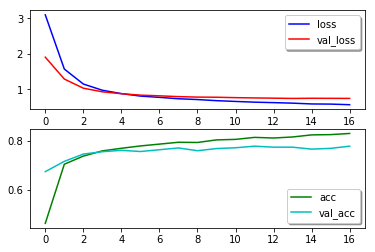

In [36]:
show_loss(inception_resnetv2_history)

## 测试数据集

In [37]:
test = pd.read_csv('sample_submission.csv')
print(test.shape)

(10357, 121)


In [38]:
n_test = len(test)
X_test = np.zeros((n_test, img_width, img_width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('test/%s.jpg' % test['id'][i]), (img_width, img_width))

100%|██████████| 10357/10357 [00:36<00:00, 282.34it/s]


In [44]:
y_pred_inceptionResNetV2 = inception_resnetv2_model.predict(X_test, batch_size=64)

In [45]:
test_copy = test.copy()
for i in breed:
    test_copy[i] = y_pred_inceptionResNetV2[:,class_to_num[i]]

In [46]:
test_copy.to_csv('pred_submission.csv', index=None)

## 数据增强

In [48]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [ ]:
img_width = 299
batch_size = 32
epochs = 20

inception_resnetv2_model = inception_resnetv2(img_width, breed_class)

# logs_file = 'model-%s-{val_loss:.4f}.h5'%str('inception_resnetv2')
logs_file = 'model-%s.h5'%str('gen_inception_resnetv2')
if not os.path.exists('model'):
    os.makedirs('model')
path_logs = os.path.join('model', logs_file)

early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_check = ModelCheckpoint(path_logs, monitor='val_loss', save_best_only=True)
    
inception_resnetv2_history1 = inception_resnetv2_model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                                                                    steps_per_epoch=len(X_train), 
                                                                    epochs=epochs,
                                                                    validation_data=(X_valid, y_valid),
                                                                    callbacks=[early_stop, model_check])

## 模型融合

In [55]:
def get_features(ft_model, preprocess_input, data, img_height=None, batch_size=64):
    if not img_height:
        img_height = 299
    inputs = Input(shape=(img_height, img_height, 3))
    input_tensor = Lambda(preprocess_input)(inputs)
    base_model = ft_model(input_tensor=input_tensor, weights='imagenet', include_top=False)
    
    x = GlobalAveragePooling2D()(base_model.output)
    model = Model(inputs=inputs, outputs=x)
    data_feature = model.predict(data, batch_size=batch_size)

    return data_feature

In [56]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_v3_preprocess_input
from keras.applications.xception import Xception, preprocess_input as xception_preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inception_resnet2_preprocess_input

InceptionResNetV2_features = get_features(InceptionResNetV2, inception_resnet2_preprocess_input, X)
InceptionV3_features = get_features(InceptionV3, inception_v3_preprocess_input, X)
Xception_features = get_features(Xception, xception_preprocess_input, X)

In [57]:
InceptionResNetV2_features.shape,InceptionV3_features.shape,Xception_features.shape

((10222, 1536), (10222, 2048), (10222, 2048))

In [58]:
data_features = np.concatenate([InceptionResNetV2_features, InceptionV3_features, Xception_features], axis=-1)

In [64]:
batch_size = 64
epochs = 15

inputs = Input(shape=(data_features.shape[1],))
x = Dropout(0.5)(inputs)
x = Dense(breed_class, activation='softmax')(x)
fetch_feature_model = Model(inputs=inputs, outputs=x)
# fetch_feature_model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
fetch_feature_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

logs_file = 'ft_extract_features.h5'
path_logs = os.path.join('model', logs_file)

early_stop = EarlyStopping(monitor='val_loss', patience=2)
model_check = ModelCheckpoint(path_logs, monitor='val_loss', save_best_only=True)
    
extract_history = fetch_feature_model.fit(data_features, y, 
                                          batch_size=batch_size, epochs=epochs, 
                                          validation_split=0.1, 
                                          callbacks=[early_stop, model_check])

Train on 9199 samples, validate on 1023 samples
Epoch 1/15
9199/9199 [==============================] - 19s 2ms/step - loss: 1.1941 - acc: 0.7116 - val_loss: 0.5344 - val_acc: 0.8358
Epoch 2/15
9199/9199 [==============================] - 1s 140us/step - loss: 0.4248 - acc: 0.8663 - val_loss: 0.4735 - val_acc: 0.8563
Epoch 3/15
9199/9199 [==============================] - 1s 135us/step - loss: 0.3152 - acc: 0.8951 - val_loss: 0.4597 - val_acc: 0.8573
Epoch 4/15
9199/9199 [==============================] - 1s 132us/step - loss: 0.2370 - acc: 0.9219 - val_loss: 0.4722 - val_acc: 0.8514
Epoch 5/15
9199/9199 [==============================] - 1s 137us/step - loss: 0.1872 - acc: 0.9413 - val_loss: 0.4537 - val_acc: 0.8612
Epoch 6/15
9199/9199 [==============================] - 1s 139us/step - loss: 0.1533 - acc: 0.9505 - val_loss: 0.4408 - val_acc: 0.8631
Epoch 7/15
9199/9199 [==============================] - 1s 137us/step - loss: 0.1325 - acc: 0.9612 - val_loss: 0.4283 - val_acc: 0.8661
E

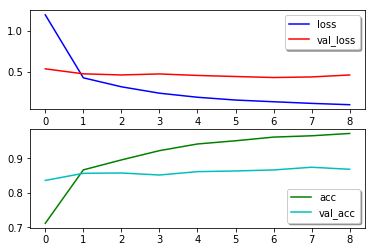

In [65]:
show_loss(extract_history)

In [66]:
InceptionResNetV2_features_test = get_features(InceptionResNetV2, inception_resnet2_preprocess_input, X_test)
InceptionV3_features_test = get_features(InceptionV3, inception_v3_preprocess_input, X_test)
Xception_features_test = get_features(Xception, xception_preprocess_input, X_test)

In [67]:
data_features_test = np.concatenate([InceptionResNetV2_features_test, InceptionV3_features_test, Xception_features_test], axis=-1)

In [69]:
y_pred = fetch_feature_model.predict(data_features_test, batch_size=64)

In [70]:
test_copy = test.copy()
for i in breed:
    test_copy[i] = y_pred[:,class_to_num[i]]

In [71]:
test_copy.to_csv('extract_pred_submission.csv', index=None)